In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import numpy as np
import scipy.stats as kurt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd


In [ ]:
datos = yf.download("^GSPC", start="2022-01-04", end="2023-09-30", rounding=True)['Close']
print(datos)

[*********************100%%**********************]  1 of 1 completed
Date
2022-01-04    4793.54
2022-01-05    4700.58
2022-01-06    4696.05
2022-01-07    4677.03
2022-01-10    4670.29
               ...   
2023-09-25    4337.44
2023-09-26    4273.53
2023-09-27    4274.51
2023-09-28    4299.70
2023-09-29    4288.05
Name: Close, Length: 437, dtype: float64


A. Realice un preprocesado de datos consistente en eliminar o corregir las
observaciones inexistentes y en eliminar observaciones influyentes alejadas en
mas/menos dos desviaciones típicas. Presente una tabla de resultados de la media, varianza, sesgo y kurtosis de la serie tratada. Dibuje también un
histograma de la misma. (2 puntos)

MEDIA: -0.0001736404162646068
VARIANZA: 0.00016372171864492235
SESGO: 0.12613327223094198
KURTOSIS: -0.961867380500613


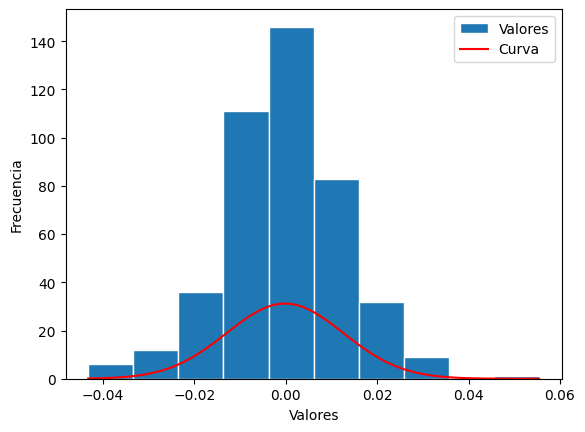

In [ ]:
serie = datos.values  #Cogemos los valores de los datos recogidos de la página
serieRentabilidad = []
serieConsistente = []
desviacionTipica = serie.std()
media = serie.mean()


#RENTABILIDAD
for i in range(1, len(datos)):
    serieRentabilidad.append((serie[i] - serie[i - 1]) / serie[i - 1])   #Calculamos rentabilidad para todos los datos y los añadimos a una lista

#ELIMINAR DATOS ATÍPICOS
for i in serie:
  if(abs(i) - media < (desviacionTipica*2)):
    serieConsistente.append(i)

#RESULTADOS

desviacionTipica = np.std(serieRentabilidad)
media = np.mean(serieRentabilidad)
varianza = desviacionTipica**2
sesgo = 3*(np.mean(serieRentabilidad) - np.median(serieRentabilidad))/desviacionTipica
curtosis = kurt.kurtosis(serieConsistente)
print("MEDIA:",media)
print("VARIANZA:",varianza)
print("SESGO:", sesgo)
print("KURTOSIS:", curtosis)
#HISTOGRAMA
plt.hist(serieRentabilidad, edgecolor = "white", label ="Valores")

#CURVA
mu, sigma = np.mean(serieRentabilidad), np.std(serieRentabilidad)
x = np.linspace(min(serieRentabilidad), max(serieRentabilidad), 100)
y = (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * ((x - mu) / sigma)**2))
plt.plot(x, y, color='r', label='Curva')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

B. A partir de dichos rendimientos deberá construir una matriz de variables
dependientes (rt) e independientes teniendo en cuenta las rentabilidades de los
cinco días anteriores, Evidentemente solo es posible construir dicha matriz a
partir de las SEXTA observación de rendimientos, debiendo descartar las filas
no completas. A partir de dicha matriz el alumno debe construir un modelo de
regresión lineal múltiple. Una vez implementado dicho modelo el alumno
deberá producir dos columnas, una con el rendimiento real del activo y otra con
el rendimiento predicho y sobre ambas calcular tres métricas: el mse, el mae y
el mape. Todos estos cálculos se deben realizar dentro de la muestra, es decir,
se refieren a la calidad de calibrado del modelo. (4 puntos)

In [ ]:
serieVectores = []
for i in range(5, len(datos) - 1):
    serieVectores.append([1, serieRentabilidad[i - 1], serieRentabilidad[i - 2], serieRentabilidad[i - 3], serieRentabilidad[i - 4], serieRentabilidad[i - 5]])  #Creamos la lista con los datos que debe llevar la matriz

#Creamos la matriz
y = np.vstack(serieRentabilidad[5:]) #Los 5 primeros datos no los agregamos ya que no es posible construir la matriz con dichos números
X = np.vstack(serieVectores)
param = np.linalg.inv(X.T @ X) @ (X.T @ y)  #Creamos el modelo lineal para conseguir los parámetros de este
print(param)

prediccion = X @ param
serieReal = np.array(serieRentabilidad[5:])
df = pd.DataFrame({'Real': serieReal, 'Predicho': prediccion.flatten()}, columns=['Real', 'Predicho'])
print(df)


# mae
mae = mean_absolute_error(serieReal, prediccion)
print("MAE: ", mae)

# mse
mse = mean_squared_error(serieReal, prediccion)
print("MSE: ", mse)

# mape
mape = mean_absolute_percentage_error(serieReal, prediccion)*100
print("MAPE: ", mape)

#rt = 0
ceros = []
for i in range (len(prediccion)):
  ceros.append(0)

# mae
mae = mean_absolute_error(prediccion, ceros)
print("MAE: ", mae)

# mse
mse = mean_squared_error(prediccion, ceros)
print("MSE: ", mse)

# mape
mape = mean_absolute_percentage_error(prediccion, ceros)*100
print("MAPE: ", mape)

[[-0.00014749]
 [ 0.00648451]
 [-0.0539616 ]
 [-0.0318776 ]
 [-0.01034046]
 [ 0.00617774]]
         Real  Predicho
0    0.002818  0.000009
1   -0.014244 -0.000542
2    0.000820 -0.000694
3   -0.018388  0.000433
4   -0.009690  0.000171
..        ...       ...
426  0.004023  0.001049
427 -0.014734  0.000609
428  0.000229 -0.000275
429  0.005893  0.000443
430 -0.002709  0.000292

[431 rows x 2 columns]
MAE:  0.009716033060463036
MSE:  0.00016383702376434548
MAPE:  111.88872121117089
MAE:  0.0006738174530387213
MSE:  7.022336274549211e-07
MAPE:  100.0


C. Para	la	siguiente	pregunta	el	alumno	debe	repetir	la	secciones	el	calculo	de	los
parámetros	del	modelo	lineal	pero	de	manera	iterada,	es	decir,	considerando
una	ventana	DESLIZANTE	de	UN	DIA	y	considerando	las	treinta	observaciones
anteriores, es	decir,	se	emplean los	últimos	30	días para	predecir	el	siguiente,
mover	un	día la	ventana	(manteniendo	los	30	últimos días)	y	volver	a	predecir,
etc..

In [ ]:
listaParam = []
tamanno = 0
while tamanno < (len(serieReal) - 30):
    yaux = y[0 + tamanno:29 + tamanno, :]
    Xaux = X[0 + tamanno:29 + tamanno, :]
    param = np.linalg.inv(Xaux.T @ Xaux) @ (Xaux.T @ yaux)
    listaParam.append(param)
    tamanno = tamanno + 1


matrixParam = np.array(listaParam)
print(matrixParam)



[[[-0.00297096]
  [ 0.18969642]
  [ 0.02105582]
  [-0.08447995]
  [-0.12614579]
  [ 0.23139461]]

 [[-0.00307945]
  [ 0.11029366]
  [ 0.01019067]
  [-0.08231066]
  [-0.21686489]
  [ 0.27545614]]

 [[-0.00192054]
  [ 0.21050166]
  [-0.05638129]
  [-0.10879547]
  [-0.21769792]
  [ 0.18107068]]

 ...

 [[-0.00109599]
  [ 0.03405705]
  [ 0.0664599 ]
  [-0.10992286]
  [ 0.00827506]
  [ 0.01439159]]

 [[-0.00110485]
  [ 0.02376454]
  [ 0.0666888 ]
  [ 0.04242213]
  [ 0.05026587]
  [-0.01146839]]

 [[-0.00085854]
  [-0.0319008 ]
  [ 0.10016613]
  [ 0.049306  ]
  [ 0.03561613]
  [-0.04990106]]]


In [ ]:

for i, param in enumerate(matrixParam):
    yaux = y[i:i+30]
    ypredicha = X[i:i+30] @ param

# mae
mae = mean_absolute_error(yaux, ypredicha)
print("MAE: ", mae)

# mse
mse = mean_squared_error(yaux, ypredicha)
print("MSE: ", mse)

# mape
mape = mean_absolute_percentage_error(yaux, ypredicha)
print("MAPE: ", mape)

MAE:  0.0061491381287910995
MSE:  5.685716206391698e-05
MAPE:  1.3853704508124298


D. En	 el	 caso	 de	 la	 ventana	 deslizante,	 suponga	 ahora	 que	 quiere	 emplear	 el
modelo	para	invertir (considere	que	no	hay	costes	de	transacción	ni	ventas	en
corto,	 es	 decir, solo	 se	 puede	 invertir	 en	 caso	 de	 una	 predicción	 de	 precio
superior	al	actual)

In [ ]:
tamanno = 0
rentabilidad = 0
while tamanno < (len(serieReal) - 30):
    yaux = y[30 + tamanno, :]
    Xaux = X[30 + tamanno, :]
    prediccion = listaParam[tamanno].T @ Xaux
    rentabilidad = rentabilidad + (prediccion - yaux)
    tamanno = tamanno + 1

print(rentabilidad)


[-0.13773426]
